In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from plotly.figure_factory import create_dendrogram
from scipy.cluster.hierarchy import fcluster, ward, dendrogram, leaves_list
from scipy.spatial.distance import pdist
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

sns.set_style('white')

In [2]:
t2_df = pd.read_csv('./t2_new.csv', sep=',', header=0, index_col=0)
t2_df.index = [i.split('.')[0] for i in t2_df.index]
print(list(t2_df.columns), '\n')
print(list(t2_df['Orientation'].unique()))
# t2_df = t2_df[t2_df.Orientation.isin(['T'])] # A, B, T

labels_ori = t2_df[['BrainRgn', 'Age', 'Sex']]

hue_type = 'BrainRgn'
# 'BrainRgn', 'Age', 'Sex'
# labels = df['Stems'].copy()

# 选择不同的bin去划分age，此时是以8作为宽度
# for i in labels_ori.index:
#     labels_ori.loc[i,'Age'] = int(labels_ori.loc[i,'Age']/4)*4

print('ori labels: ',labels_ori[hue_type].unique())
print(labels_ori[hue_type].value_counts(), '\n')

# 1 只包括5类regions
# labels = labels_ori.loc[~labels_ori.BrainRgn.isin(['SMFG', 'SMIFG','SFG','MTG','IFG']), [hue_type]]
# labels_ori = labels_ori[~labels_ori.BrainRgn.isin(['SMFG', 'SMIFG','SFG','MTG','IFG'])]

# 2 只包括PL IPL
# labels = labels_ori.loc[labels_ori.BrainRgn.isin(['PL','IPL']), [hue_type]]
# labels_ori = labels_ori[labels_ori.BrainRgn.isin(['PL','IPL'])]

## 3 全部
labels = labels_ori[[hue_type]]

# 选择特征范围
# 6维
# df = t2_df[['Stems', 'Branches', 'Length', 'AverageBifurcationAngleLocal','AverageBifurcationAngleRemote', 'HausdorffDimension']]
# 22 维
df = t2_df.iloc[:, 4:]
df = df.loc[labels.index,:]

print('after labels: ', labels[hue_type].unique())
print(labels[hue_type].value_counts())
labels

['Orientation', 'BrainRgn', 'Age', 'Sex', 'Nodes', 'SomaSurface', 'Stems', 'Bifurcations', 'Branches', 'Tips', 'OverallWidth', 'OverallHeight', 'OverallDepth', 'AverageDiameter', 'Length', 'Surface', 'Volume', 'MaxEuclideanDistance', 'MaxPathDistance', 'MaxBranchOrder', 'AverageContraction', 'AverageFragmentation', 'AverageParent-daughterRatio', 'AverageBifurcationAngleLocal', 'AverageBifurcationAngleRemote', 'HausdorffDimension'] 

['B', 'T', 'A']
ori labels:  ['MFG' 'SFG' 'IPL' 'IFG' 'STG' 'MTG' 'TP' 'PL' 'SMFG' 'SMIFG']
MFG      304
TP       174
STG      131
IPL      112
PL        91
SFG       14
MTG       12
SMFG       5
SMIFG      5
IFG        4
Name: BrainRgn, dtype: int64 

after labels:  ['MFG' 'SFG' 'IPL' 'IFG' 'STG' 'MTG' 'TP' 'PL' 'SMFG' 'SMIFG']
MFG      304
TP       174
STG      131
IPL      112
PL        91
SFG       14
MTG       12
SMFG       5
SMIFG      5
IFG        4
Name: BrainRgn, dtype: int64


,BrainRgn
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,MFG
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,MFG
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,MFG
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,MFG
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,MFG
...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,PL
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,PL
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,PL
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,PL


In [3]:
labels_ori

,BrainRgn,Age,Sex
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,MFG,49,M
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,MFG,49,M
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,MFG,49,M
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,MFG,49,M
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,MFG,49,M
...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,PL,41,F
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,PL,41,F
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,PL,41,F
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,PL,41,F


In [4]:
df

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,Volume,MaxEuclideanDistance,MaxPathDistance,MaxBranchOrder,AverageContraction,AverageFragmentation,AverageParent-daughterRatio,AverageBifurcationAngleLocal,AverageBifurcationAngleRemote,HausdorffDimension
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,1749,12.5664,8,40,86,47,223.100,230.920,104.000,1.99886,...,7979.01,140.560,161.173,5,0.913690,19.3256,1.000000,88.3595,60.3844,1.06136
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,1777,12.5664,8,31,68,38,213.900,223.560,107.333,1.99887,...,7703.82,137.156,181.177,7,0.905318,25.1176,1.000000,75.3405,55.8170,1.10491
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,1639,12.5664,8,33,72,40,206.080,218.040,109.000,1.99878,...,7415.34,136.949,184.228,6,0.903052,21.7500,1.000000,76.2666,59.6023,1.07386
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,1143,12.5664,10,37,82,46,164.220,149.960,87.000,2.07772,...,16137.40,121.641,145.138,7,0.884827,12.9268,1.233460,68.6457,74.3453,1.11178
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,1309,25048.1000,11,47,104,58,230.920,209.760,149.000,2.24216,...,50325.50,149.189,209.372,9,0.932546,11.5769,0.863606,69.6403,59.4337,1.10682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,724,12.5664,8,25,56,32,157.320,168.360,92.708,1.99724,...,5238.61,152.675,179.698,4,0.934485,11.9107,1.000000,68.2542,55.4037,1.04172
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,1490,12.5664,10,31,70,40,188.140,176.640,89.000,1.99866,...,6543.71,120.939,143.704,7,0.908536,20.2714,1.000000,77.3570,62.6581,1.05175
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,906,12.5664,5,36,75,40,194.120,228.160,79.000,1.99779,...,5468.23,144.298,176.232,8,0.921007,11.0667,1.000000,88.5365,58.5789,1.04628
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,1953,12.5664,9,45,98,54,310.791,270.946,107.000,1.99898,...,10330.40,195.884,217.704,8,0.904601,18.9184,1.000000,82.1884,56.0901,1.11766


In [5]:
x = df.values
x.shape

(852, 22)

In [6]:
std = StandardScaler()
# pca = PCA(0.99)

In [7]:
x_std = std.fit_transform(x)
print('x_std shape: ', x_std.shape)

# x_pca = pca.fit_transform(x_std)
# print('x_pca shape: ', x_pca.shape)

x_std shape:  (852, 22)


In [8]:
df

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,Volume,MaxEuclideanDistance,MaxPathDistance,MaxBranchOrder,AverageContraction,AverageFragmentation,AverageParent-daughterRatio,AverageBifurcationAngleLocal,AverageBifurcationAngleRemote,HausdorffDimension
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,1749,12.5664,8,40,86,47,223.100,230.920,104.000,1.99886,...,7979.01,140.560,161.173,5,0.913690,19.3256,1.000000,88.3595,60.3844,1.06136
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,1777,12.5664,8,31,68,38,213.900,223.560,107.333,1.99887,...,7703.82,137.156,181.177,7,0.905318,25.1176,1.000000,75.3405,55.8170,1.10491
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,1639,12.5664,8,33,72,40,206.080,218.040,109.000,1.99878,...,7415.34,136.949,184.228,6,0.903052,21.7500,1.000000,76.2666,59.6023,1.07386
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,1143,12.5664,10,37,82,46,164.220,149.960,87.000,2.07772,...,16137.40,121.641,145.138,7,0.884827,12.9268,1.233460,68.6457,74.3453,1.11178
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,1309,25048.1000,11,47,104,58,230.920,209.760,149.000,2.24216,...,50325.50,149.189,209.372,9,0.932546,11.5769,0.863606,69.6403,59.4337,1.10682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,724,12.5664,8,25,56,32,157.320,168.360,92.708,1.99724,...,5238.61,152.675,179.698,4,0.934485,11.9107,1.000000,68.2542,55.4037,1.04172
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,1490,12.5664,10,31,70,40,188.140,176.640,89.000,1.99866,...,6543.71,120.939,143.704,7,0.908536,20.2714,1.000000,77.3570,62.6581,1.05175
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,906,12.5664,5,36,75,40,194.120,228.160,79.000,1.99779,...,5468.23,144.298,176.232,8,0.921007,11.0667,1.000000,88.5365,58.5789,1.04628
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,1953,12.5664,9,45,98,54,310.791,270.946,107.000,1.99898,...,10330.40,195.884,217.704,8,0.904601,18.9184,1.000000,82.1884,56.0901,1.11766


In [9]:
# df_std = pd.DataFrame(
#             x_std,
#             columns=df.columns, 
#             index=df.index
#             )
# df_std['hue'] = labels
# df_std

In [10]:
df['hue'] = labels
df

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,MaxEuclideanDistance,MaxPathDistance,MaxBranchOrder,AverageContraction,AverageFragmentation,AverageParent-daughterRatio,AverageBifurcationAngleLocal,AverageBifurcationAngleRemote,HausdorffDimension,hue
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,1749,12.5664,8,40,86,47,223.100,230.920,104.000,1.99886,...,140.560,161.173,5,0.913690,19.3256,1.000000,88.3595,60.3844,1.06136,MFG
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,1777,12.5664,8,31,68,38,213.900,223.560,107.333,1.99887,...,137.156,181.177,7,0.905318,25.1176,1.000000,75.3405,55.8170,1.10491,MFG
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,1639,12.5664,8,33,72,40,206.080,218.040,109.000,1.99878,...,136.949,184.228,6,0.903052,21.7500,1.000000,76.2666,59.6023,1.07386,MFG
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,1143,12.5664,10,37,82,46,164.220,149.960,87.000,2.07772,...,121.641,145.138,7,0.884827,12.9268,1.233460,68.6457,74.3453,1.11178,MFG
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,1309,25048.1000,11,47,104,58,230.920,209.760,149.000,2.24216,...,149.189,209.372,9,0.932546,11.5769,0.863606,69.6403,59.4337,1.10682,MFG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,724,12.5664,8,25,56,32,157.320,168.360,92.708,1.99724,...,152.675,179.698,4,0.934485,11.9107,1.000000,68.2542,55.4037,1.04172,PL
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,1490,12.5664,10,31,70,40,188.140,176.640,89.000,1.99866,...,120.939,143.704,7,0.908536,20.2714,1.000000,77.3570,62.6581,1.05175,PL
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,906,12.5664,5,36,75,40,194.120,228.160,79.000,1.99779,...,144.298,176.232,8,0.921007,11.0667,1.000000,88.5365,58.5789,1.04628,PL
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,1953,12.5664,9,45,98,54,310.791,270.946,107.000,1.99898,...,195.884,217.704,8,0.904601,18.9184,1.000000,82.1884,56.0901,1.11766,PL


In [11]:
# sns.set_style('white')
# plt.figure(figsize=(15,15))
# sns.pairplot(df, hue='hue', 
# #              palette='Reds',
#              palette='Set1', 
#              diag_kind='hist')
# plt.savefig('./pairplot_raw_'+hue_type+'.png', dpi=200)

In [12]:
# plt.figure(figsize=(15,15))
# sns.pairplot(df_std, hue='hue', palette='Set2', diag_kind='hist')
# plt.savefig('./pairplot_std_'+hue_type+'.png', dpi=200)

In [13]:
my_umap = UMAP(n_components=2,n_neighbors=30, random_state=10, min_dist=0.2)
# my_umap = UMAP(n_components=2,n_neighbors=int(len(x)/3), random_state=10, min_dist=0.2)

x_umap = my_umap.fit_transform(x_std.copy()) # 输入可以选择为x_std或者x_pca
figure_df = pd.DataFrame({
#     'x_pca':x_pca[:,0],
#     'y_pca':x_pca[:,1],
    'hue':df['hue'],
    'x_umap':x_umap[:,0],
    'y_umap':x_umap[:,1]
#     'neuron_id':subtype_data.index.tolist()
    })
# figure_df['hue'] = figure_df['hue'].astype(float)
# figure_df


In [14]:
figure_df

,hue,x_umap,y_umap
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,MFG,10.082899,15.672231
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,MFG,9.920910,15.271092
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,MFG,9.879328,15.425721
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,MFG,11.588934,12.861104
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,MFG,5.675815,10.999753
...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,PL,10.685925,12.578744
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,PL,11.218996,14.873777
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,PL,10.568617,13.106037
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,PL,6.558276,13.417336


<AxesSubplot:xlabel='x_umap', ylabel='y_umap'>

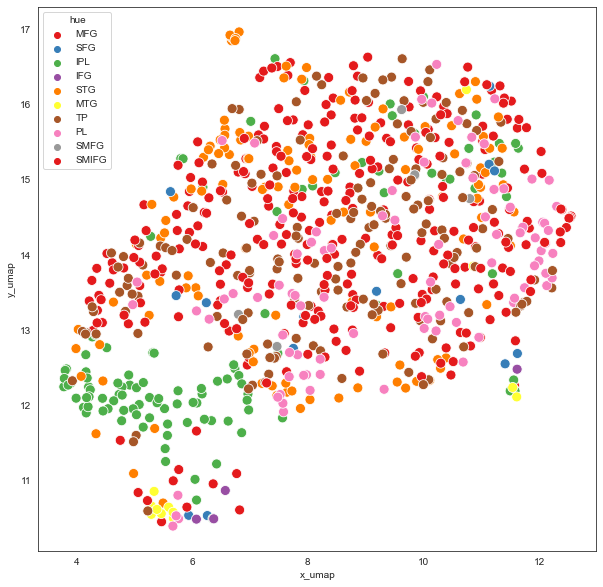

In [15]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=figure_df['x_umap'], y=figure_df['y_umap'], hue=figure_df['hue'],
               palette='Set1', # 离散配色方案
#                palette=sns.diverging_palette(240, 10, n=10, as_cmap=True), # 连续配色方案
               s=100,
#                hue_norm=(-100,100)
               )
# plt.savefig('./umap_'+hue_type+'.png', dpi=200)

In [16]:
sns.light_palette((260, 75, 60), input="husl")

[(0.9421819918111672, 0.9432266193679569, 0.9498462205167962),
 (0.8469568241944938, 0.8640574828228126, 0.9383849551740686),
 (0.7517316565778204, 0.7848883462776681, 0.9269236898313409),
 (0.6565064889611469, 0.7057192097325238, 0.9154624244886133),
 (0.5612813213444735, 0.6265500731873794, 0.9040011591458855),
 (0.4660561537278001, 0.5473809366422351, 0.8925398938031579)]

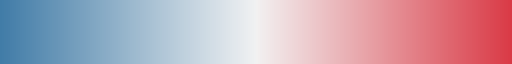

In [17]:
#                 'Set1',
sns.diverging_palette(240, 10, n=6, as_cmap=True)

In [18]:
print(np.hstack(np.argwhere(figure_df['hue'].values=='PL')).shape)

(91,)


In [19]:
print(np.hstack(np.argwhere(figure_df['hue'].values=='IPL')).shape)

(112,)


In [21]:
def func(X):
    return pdist(X, metric='cosine')

In [ ]:
# 选择PL, IPL数据

# x_den0 = x_std[np.hstack(np.argwhere(figure_df['hue'].values=='PL')),:]
# print('x_den0 shape ', x_den0.shape)
# x_den1 = x_std[np.hstack(np.argwhere(figure_df['hue'].values=='IPL')),:]
# print('x_den1 shape ', x_den1.shape)


In [22]:
# 画PL的dendrogram图

fig = create_dendrogram(x_den0, 
                        colorscale=['rgb(55,126,184)','rgb(55,126,184)', 'rgb(55,126,184)'],
                        color_threshold=4.5,
                        distfun = func,
                        linkagefun=ward
                       )

fig.update_layout(template='plotly_white',        
                  width=1000,
                  height=500,
                  xaxis = {'tickangle':90},
                  title='dendrogram '+hue_type+' PL',
                 )
fig.show()


In [23]:
# 画IPL的dendrogram图


fig = create_dendrogram(x_den1, colorscale=['red','red', 'red'],
                        color_threshold=7,
                        distfun = func,
                        linkagefun=ward)
fig.update_layout(template='plotly_white',        
                  width=1000,
                  height=500,
                  xaxis = {'tickangle':90},
                  title='dendrogram '+hue_type+' IPL',
                 )
fig.show()


## 22、6维的聚类

In [24]:
labels_ori = labels_ori.loc[figure_df.index,:]
labels_ori

,BrainRgn,Age,Sex
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,MFG,49,M
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,MFG,49,M
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,MFG,49,M
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,MFG,49,M
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,MFG,49,M
...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,PL,41,F
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,PL,41,F
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,PL,41,F
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,PL,41,F


In [25]:
x_std.shape

(852, 22)

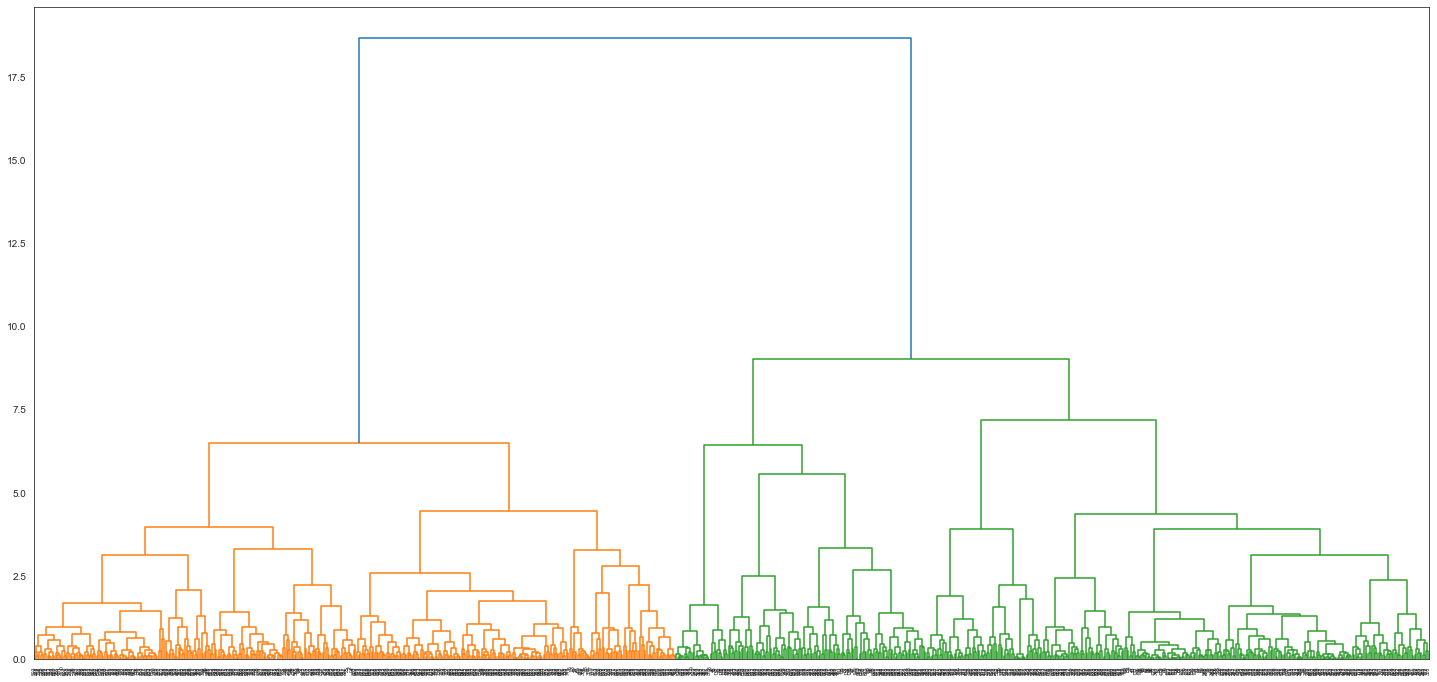

In [26]:
# x_std作为输入的聚类树状图

sns.set_style('white')
Z = ward(func(x_std))
fig = plt.figure(figsize=(25, 12))
dn = dendrogram(Z)
# plt.show()
plt.savefig('./dendrogram.png', dpi=200, bbox_inches='tight')

In [27]:
labels0 = fcluster(Z, t=6, criterion='distance')
labels_ori['labels'] = labels0
for i in range(10):
    labels_ori['random_labels'+str(i+1)] = np.random.randint(1,len(np.unique(labels0)),len(labels0))
print(np.unique(labels0))
print(labels0)
labels_ori

[1 2 3 4 5 6]
[1 1 1 2 6 2 2 2 3 3 2 2 3 6 6 3 2 4 2 2 3 2 3 5 6 1 1 1 1 5 4 1 4 2 3 2 3
 2 6 4 6 6 6 6 6 1 6 4 1 6 6 6 6 6 6 6 6 1 1 6 1 6 6 4 3 1 4 6 6 6 6 6 4 6
 4 1 4 6 2 4 2 4 4 6 1 5 1 6 6 6 6 1 1 6 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4
 4 2 4 1 6 4 5 4 6 6 6 6 6 2 3 4 6 6 6 6 6 4 3 1 3 2 3 3 1 6 6 5 6 6 6 6 6
 6 5 5 6 6 1 5 2 6 1 1 1 1 4 1 2 1 1 1 6 6 6 2 2 6 1 6 2 1 2 1 1 2 1 1 4 1
 2 6 6 1 1 4 6 1 1 5 1 5 2 1 4 5 4 1 5 1 4 6 1 1 1 1 1 6 1 1 4 1 1 4 2 2 2
 1 5 6 6 5 6 1 1 4 5 6 1 2 1 6 4 5 6 6 4 4 6 6 5 5 1 1 1 1 4 4 1 4 6 4 1 4
 4 4 4 4 5 4 6 6 6 6 1 6 5 5 5 3 5 1 5 6 6 5 5 5 5 5 1 6 6 2 6 1 6 1 2 5 6
 1 1 1 1 2 6 1 1 5 1 5 6 6 6 6 6 6 6 6 6 5 1 5 6 2 5 6 1 1 6 5 6 4 2 2 1 2
 4 1 2 2 1 2 2 1 6 3 6 6 5 2 6 3 6 4 1 6 3 3 3 3 3 2 2 1 3 2 3 3 4 6 1 4 6
 5 6 5 2 5 5 3 2 1 1 1 2 2 2 2 6 6 6 1 2 1 1 6 5 6 5 5 4 6 6 1 6 1 3 5 1 6
 6 6 5 5 2 5 1 5 1 1 1 5 1 6 1 1 4 1 1 6 1 2 2 2 1 5 6 1 2 6 6 2 5 6 2 2 6
 2 1 6 4 6 6 6 2 2 6 2 2 6 1 6 6 5 6 5 1 5 6 6 5 6 6 6 1 6 6 6 6 6 6 6 1 1
 6 6 6 4 6 

,BrainRgn,Age,Sex,labels,random_labels1,random_labels2,random_labels3,random_labels4,random_labels5,random_labels6,random_labels7,random_labels8,random_labels9,random_labels10
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,MFG,49,M,1,1,1,4,4,3,2,5,4,3,1
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,MFG,49,M,1,5,3,3,5,5,1,1,2,5,1
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,MFG,49,M,1,5,5,5,3,1,1,2,5,2,2
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,MFG,49,M,2,3,4,3,4,4,5,4,2,5,5
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,MFG,49,M,6,1,1,3,4,4,3,5,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,PL,41,F,2,4,1,5,4,2,2,4,4,3,1
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,PL,41,F,1,3,4,1,3,2,1,4,5,3,2
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,PL,41,F,2,5,4,5,2,1,1,5,1,1,5
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,PL,41,F,6,5,3,2,1,4,1,5,2,5,3


In [28]:
new_index = leaves_list(Z)
x_std_re = x_std[new_index]
labels_ori_re = labels_ori.iloc[new_index, :]
print(x_std_re.shape)
labels_ori_re

(852, 22)


,BrainRgn,Age,Sex,labels,random_labels1,random_labels2,random_labels3,random_labels4,random_labels5,random_labels6,random_labels7,random_labels8,random_labels9,random_labels10
00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_stamp_2022_08_18_16_55,TP,41,M,1,3,2,1,2,2,2,2,1,4,4
00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_stamp_2022_08_30_14_24,MFG,36,F,1,2,5,4,1,1,5,5,1,3,2
00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_stamp_2022_07_28_11_01,TP,41,M,1,5,4,4,2,4,2,4,1,3,1
00607_P006_T01-S005_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_16_32,STG,63,M,1,3,4,3,5,1,4,5,1,4,4
00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_GYC_stamp_2022_08_30_09_25,IPL,49,F,1,5,1,4,4,2,3,4,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00771_P005_T01-S014_MFG_R0509_LJ-20220525_LJ_stamp_2022_08_12_16_45,MFG,36,F,6,2,5,5,2,5,2,1,2,2,3
00591_P006_T01-S003_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_11_05,STG,63,M,6,5,5,2,2,4,2,2,5,5,1
00865_P010_T01-S010_TP_R0509_LJ-20220607_LJ_stamp_2022_07_25_17_21,TP,41,M,6,4,1,3,3,4,5,2,2,5,2
00381_P005_T01-S005_MFG_R0509_LJ-20220525_YXQ_stamp_2022_07_21_16_35,MFG,36,F,6,5,4,3,3,4,3,1,4,1,1


In [29]:
corre_matrix = np.eye((len(labels_ori_re)), len(labels_ori_re))
for i in range(len(corre_matrix)):
    for j in range(len(corre_matrix)):
        if j == i:
            continue

#         tmp = np.corrcoef(x_pca_re[i], x_pca_re[j])
#         corre_matrix[i,j] = tmp[0][1]
        tmp = cosine_similarity(x_std_re[i].reshape(1, -1), x_std_re[j].reshape(1, -1))
        corre_matrix[i,j] = tmp

In [30]:
corre_matrix

array([[ 1.00000000e+00,  8.06874045e-01,  8.18054843e-01, ...,
        -1.50828614e-01,  4.23547196e-02,  2.62080884e-01],
       [ 8.06874045e-01,  1.00000000e+00,  9.00941657e-01, ...,
         1.12369814e-02,  1.90966293e-02,  2.56181252e-01],
       [ 8.18054843e-01,  9.00941657e-01,  1.00000000e+00, ...,
        -2.67869370e-01,  6.46590794e-04,  1.09212376e-01],
       ...,
       [-1.50828614e-01,  1.12369814e-02, -2.67869370e-01, ...,
         1.00000000e+00,  5.60747749e-01,  5.96001213e-01],
       [ 4.23547196e-02,  1.90966293e-02,  6.46590794e-04, ...,
         5.60747749e-01,  1.00000000e+00,  7.55864256e-01],
       [ 2.62080884e-01,  2.56181252e-01,  1.09212376e-01, ...,
         5.96001213e-01,  7.55864256e-01,  1.00000000e+00]])

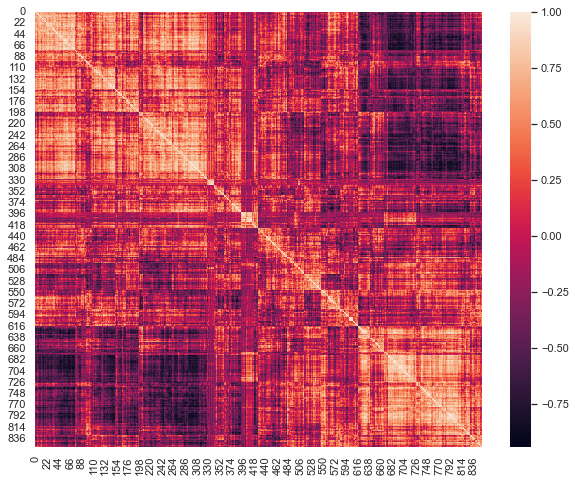

In [31]:
sns.set(style='white', )
f, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(corre_matrix, ax=ax)
plt.savefig('corre_matrix_heatmap.png', dpi=200, bbox_inches='tight')

In [32]:
# print(mutual_info_score(labels_ori['labels'], labels_ori['BrainRgn']))
# print(mutual_info_score(labels_ori['labels'], labels_ori['Age']))
# print(mutual_info_score(labels_ori['labels'], labels_ori['Sex']))
MI_df = pd.DataFrame(columns=['lable_type', 'hue_type', 'NMI'])
for lt_i in ['labels']+['random_labels'+str(i+1) for i in range(10)]:
    for ht_j in ['BrainRgn', 'Age', 'Sex']:
        if lt_i.startswith('random'):
            lt_i1 = 'random_labels'
        else:
            lt_i1 = lt_i
        tmp_df = pd.DataFrame({'lable_type':[lt_i1], 'hue_type': [ht_j], 'NMI':[normalized_mutual_info_score(labels_ori[lt_i], labels_ori[ht_j])]})
        MI_df = pd.concat([MI_df, tmp_df], axis=0)
MI_df

,lable_type,hue_type,NMI
0,labels,BrainRgn,0.073575
0,labels,Age,0.086434
0,labels,Sex,0.014040
0,random_labels,BrainRgn,0.012459
0,random_labels,Age,0.019426
0,random_labels,Sex,0.004307
0,random_labels,BrainRgn,0.015098
0,random_labels,Age,0.022018
0,random_labels,Sex,0.000979
0,random_labels,BrainRgn,0.012111


In [33]:
group_values = MI_df.groupby(['hue_type','lable_type']).mean().reset_index()
# group_values.sort_values('hue_type', o)
group_values

,hue_type,lable_type,NMI
0,Age,labels,0.086434
1,Age,random_labels,0.019386
2,BrainRgn,labels,0.073575
3,BrainRgn,random_labels,0.013756
4,Sex,labels,0.014040
5,Sex,random_labels,0.002581


In [34]:
# print(mutual_info_score(labels_ori['random_labels'], labels_ori['BrainRgn']))
# print(mutual_info_score(labels_ori['random_labels'], labels_ori['Age']))
# print(mutual_info_score(labels_ori['random_labels'], labels_ori['Sex']))


In [35]:
coordinates_dict = {'Age':0, 'BrainRgn':1, 'Sex':2}
offset_dict = {'labels':-0.2, 'random_labels':0.2}

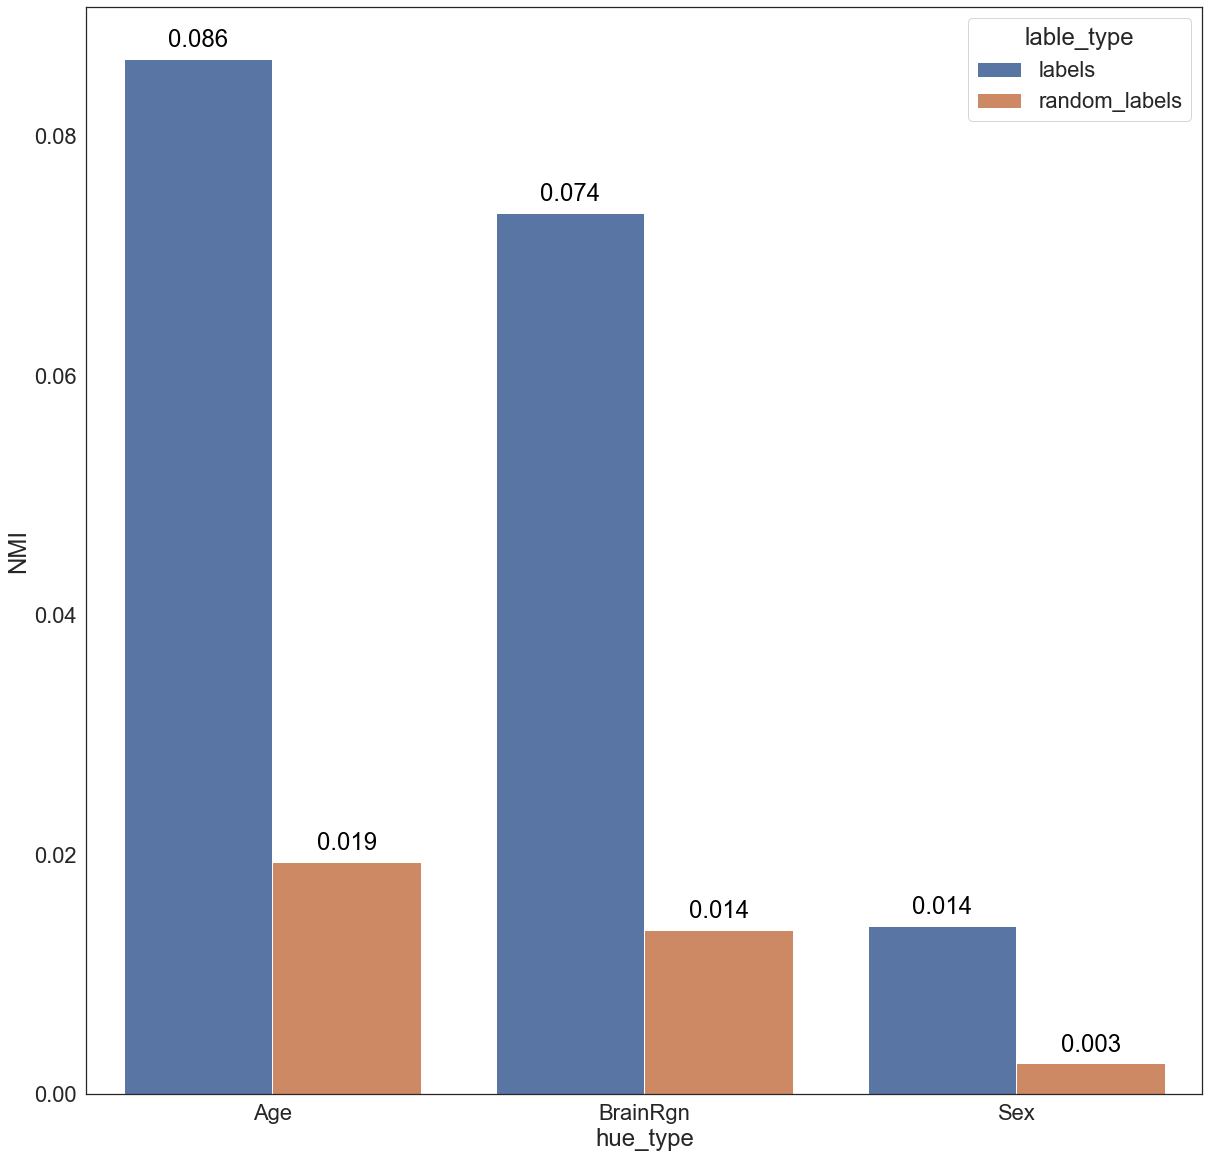

In [36]:
sns.set(style='white', font_scale=2,)
plt.figure(figsize=(20,20))
g = sns.barplot(data = group_values, x='hue_type', y='NMI', hue='lable_type')

for index,row in group_values.iterrows():
    g.text(coordinates_dict[row.hue_type]+offset_dict[row.lable_type], row.NMI+0.001, round(row.NMI,3),color="black",ha="center")
plt.savefig('./MI.png', dpi=200, bbox_inches='tight')

In [37]:
# print(row)
# print(g.get_xticklabels())

In [38]:
labels_ori_re['top1'] = 0
labels_ori_re['top2'] = 0
labels_ori_re['top3'] = 0
labels_ori_re['top4'] = 0
labels_ori_re['top5'] = 0
labels_ori_re

,BrainRgn,Age,Sex,labels,random_labels1,random_labels2,random_labels3,random_labels4,random_labels5,random_labels6,random_labels7,random_labels8,random_labels9,random_labels10,top1,top2,top3,top4,top5
00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_stamp_2022_08_18_16_55,TP,41,M,1,3,2,1,2,2,2,2,1,4,4,0,0,0,0,0
00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_stamp_2022_08_30_14_24,MFG,36,F,1,2,5,4,1,1,5,5,1,3,2,0,0,0,0,0
00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_stamp_2022_07_28_11_01,TP,41,M,1,5,4,4,2,4,2,4,1,3,1,0,0,0,0,0
00607_P006_T01-S005_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_16_32,STG,63,M,1,3,4,3,5,1,4,5,1,4,4,0,0,0,0,0
00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_GYC_stamp_2022_08_30_09_25,IPL,49,F,1,5,1,4,4,2,3,4,3,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00771_P005_T01-S014_MFG_R0509_LJ-20220525_LJ_stamp_2022_08_12_16_45,MFG,36,F,6,2,5,5,2,5,2,1,2,2,3,0,0,0,0,0
00591_P006_T01-S003_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_11_05,STG,63,M,6,5,5,2,2,4,2,2,5,5,1,0,0,0,0,0
00865_P010_T01-S010_TP_R0509_LJ-20220607_LJ_stamp_2022_07_25_17_21,TP,41,M,6,4,1,3,3,4,5,2,2,5,2,0,0,0,0,0
00381_P005_T01-S005_MFG_R0509_LJ-20220525_YXQ_stamp_2022_07_21_16_35,MFG,36,F,6,5,4,3,3,4,3,1,4,1,1,0,0,0,0,0


In [39]:
for k,i in enumerate(labels_ori_re.index):
    topkmax_args = list(np.argsort(corre_matrix[k], axis=-1)[::-1][0:6])
    topkmax_args.remove(k)
    for k,topi in enumerate(topkmax_args):
        labels_ori_re.loc[i, 'top'+str(k+1)] = labels_ori_re.index[topi]
labels_ori_re

,BrainRgn,Age,Sex,labels,random_labels1,random_labels2,random_labels3,random_labels4,random_labels5,random_labels6,random_labels7,random_labels8,random_labels9,random_labels10,top1,top2,top3,top4,top5
00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_stamp_2022_08_18_16_55,TP,41,M,1,3,2,1,2,2,2,2,1,4,4,00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_G...,00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_s...,00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,00341_P005_T01-S016_MFG_R0509_LJ-20220525_YXQ_...
00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_stamp_2022_08_30_14_24,MFG,36,F,1,2,5,4,1,1,5,5,1,3,2,00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_s...,00534_P006_T01-S002_STG_R0509_LJ-20220530_YXQ_...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,01587_P018_T01-S012_SPL_R0460_LJ-20220728_LJ_s...,00643_P006_T01-S004_STG_R0509_LJ-20220530_LJ_s...
00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_stamp_2022_07_28_11_01,TP,41,M,1,5,4,4,2,4,2,4,1,3,1,00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...,00930_P009_T01-S026_SFG_R0509_LJ-20220603_XJ_s...,00893_P010_T01-S012_TP_R0509_LJ-20220607_XJ_st...,00341_P005_T01-S016_MFG_R0509_LJ-20220525_YXQ_...,00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_st...
00607_P006_T01-S005_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_16_32,STG,63,M,1,3,4,3,5,1,4,5,1,4,4,00471_P005_T01-S005_MFG_R0509_LJ-20220525_LJ_s...,00989_P010_T01-S019_TP_R0509_LJ-20220607_YXQ_s...,00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_G...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...
00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_GYC_stamp_2022_08_30_09_25,IPL,49,F,1,5,1,4,4,2,3,4,3,1,1,00471_P005_T01-S005_MFG_R0509_LJ-20220525_LJ_s...,00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_st...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,00959_P011_T01-S002_STG-AP_R0460_WY-20220610_X...,01471_P014_T01-S004_MFG_R0460_LJ-20220704_LJ_s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00771_P005_T01-S014_MFG_R0509_LJ-20220525_LJ_stamp_2022_08_12_16_45,MFG,36,F,6,2,5,5,2,5,2,1,2,2,3,00322_P005_T01-S003_MFG_R0509_LJ-20220525_GSX_...,00638_P006_T01-S004_STG_R0509_LJ-20220530_LJ_s...,00606_P006_T01-S005_STG_R0509_LJ-20220530_LJ_s...,00309_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...,00313_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...
00591_P006_T01-S003_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_11_05,STG,63,M,6,5,5,2,2,4,2,2,5,5,1,00865_P010_T01-S010_TP_R0509_LJ-20220607_LJ_st...,00606_P006_T01-S005_STG_R0509_LJ-20220530_LJ_s...,00309_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...,00626_P006_T01-S004_STG_R0509_LJ-20220530_XJ_s...,00322_P005_T01-S003_MFG_R0509_LJ-20220525_GSX_...
00865_P010_T01-S010_TP_R0509_LJ-20220607_LJ_stamp_2022_07_25_17_21,TP,41,M,6,4,1,3,3,4,5,2,2,5,2,00591_P006_T01-S003_STG_R0509_LJ-20220530_XJ_s...,00606_P006_T01-S005_STG_R0509_LJ-20220530_LJ_s...,00635_P006_T01-S004_STG_R0509_LJ-20220530_LJ_s...,00514_P005_T01-S007_MFG_R0509_LJ-20220525_YXQ_...,00725_P005_T01-S011_MFG_R0509_LJ-20220525_LJ_s...
00381_P005_T01-S005_MFG_R0509_LJ-20220525_YXQ_stamp_2022_07_21_16_35,MFG,36,F,6,5,4,3,3,4,3,1,4,1,1,00246_P003_T01-S004_S(M)TG_R0460_WY-20220513_L...,00738_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...,00315_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...,00751_P005_T01-S011_MFG_R0678_LJ-20220525_XJ_s...,00309_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...


In [40]:
labels_ori_re.to_csv('./clustering_result.csv', sep=',')

In [41]:
labels_ori_re

,BrainRgn,Age,Sex,labels,random_labels1,random_labels2,random_labels3,random_labels4,random_labels5,random_labels6,random_labels7,random_labels8,random_labels9,random_labels10,top1,top2,top3,top4,top5
00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_stamp_2022_08_18_16_55,TP,41,M,1,3,2,1,2,2,2,2,1,4,4,00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_G...,00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_s...,00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,00341_P005_T01-S016_MFG_R0509_LJ-20220525_YXQ_...
00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_stamp_2022_08_30_14_24,MFG,36,F,1,2,5,4,1,1,5,5,1,3,2,00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_s...,00534_P006_T01-S002_STG_R0509_LJ-20220530_YXQ_...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,01587_P018_T01-S012_SPL_R0460_LJ-20220728_LJ_s...,00643_P006_T01-S004_STG_R0509_LJ-20220530_LJ_s...
00851_P010_T01-S008_TP_R0509_LJ-20220607_YXQ_stamp_2022_07_28_11_01,TP,41,M,1,5,4,4,2,4,2,4,1,3,1,00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...,00930_P009_T01-S026_SFG_R0509_LJ-20220603_XJ_s...,00893_P010_T01-S012_TP_R0509_LJ-20220607_XJ_st...,00341_P005_T01-S016_MFG_R0509_LJ-20220525_YXQ_...,00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_st...
00607_P006_T01-S005_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_16_32,STG,63,M,1,3,4,3,5,1,4,5,1,4,4,00471_P005_T01-S005_MFG_R0509_LJ-20220525_LJ_s...,00989_P010_T01-S019_TP_R0509_LJ-20220607_YXQ_s...,00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_G...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,00730_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...
00156_P003_T01-S005_S(M)TG_R0613_WY-20220513_GYC_stamp_2022_08_30_09_25,IPL,49,F,1,5,1,4,4,2,3,4,3,1,1,00471_P005_T01-S005_MFG_R0509_LJ-20220525_LJ_s...,00920_P010_T01-S007_TP_R0678_LJ-20220607_LJ_st...,00915_P011_T01-S001_STG-AP_R0509_WY-20220610_L...,00959_P011_T01-S002_STG-AP_R0460_WY-20220610_X...,01471_P014_T01-S004_MFG_R0460_LJ-20220704_LJ_s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00771_P005_T01-S014_MFG_R0509_LJ-20220525_LJ_stamp_2022_08_12_16_45,MFG,36,F,6,2,5,5,2,5,2,1,2,2,3,00322_P005_T01-S003_MFG_R0509_LJ-20220525_GSX_...,00638_P006_T01-S004_STG_R0509_LJ-20220530_LJ_s...,00606_P006_T01-S005_STG_R0509_LJ-20220530_LJ_s...,00309_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...,00313_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...
00591_P006_T01-S003_STG_R0509_LJ-20220530_XJ_stamp_2022_08_04_11_05,STG,63,M,6,5,5,2,2,4,2,2,5,5,1,00865_P010_T01-S010_TP_R0509_LJ-20220607_LJ_st...,00606_P006_T01-S005_STG_R0509_LJ-20220530_LJ_s...,00309_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...,00626_P006_T01-S004_STG_R0509_LJ-20220530_XJ_s...,00322_P005_T01-S003_MFG_R0509_LJ-20220525_GSX_...
00865_P010_T01-S010_TP_R0509_LJ-20220607_LJ_stamp_2022_07_25_17_21,TP,41,M,6,4,1,3,3,4,5,2,2,5,2,00591_P006_T01-S003_STG_R0509_LJ-20220530_XJ_s...,00606_P006_T01-S005_STG_R0509_LJ-20220530_LJ_s...,00635_P006_T01-S004_STG_R0509_LJ-20220530_LJ_s...,00514_P005_T01-S007_MFG_R0509_LJ-20220525_YXQ_...,00725_P005_T01-S011_MFG_R0509_LJ-20220525_LJ_s...
00381_P005_T01-S005_MFG_R0509_LJ-20220525_YXQ_stamp_2022_07_21_16_35,MFG,36,F,6,5,4,3,3,4,3,1,4,1,1,00246_P003_T01-S004_S(M)TG_R0460_WY-20220513_L...,00738_P005_T01-S011_MFG_R0509_LJ-20220525_YXQ_...,00315_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...,00751_P005_T01-S011_MFG_R0678_LJ-20220525_XJ_s...,00309_P005_T01-S001_MFG_R0509_GYC-20220525_GYC...


In [42]:
t2_df

,Orientation,BrainRgn,Age,Sex,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,...,Volume,MaxEuclideanDistance,MaxPathDistance,MaxBranchOrder,AverageContraction,AverageFragmentation,AverageParent-daughterRatio,AverageBifurcationAngleLocal,AverageBifurcationAngleRemote,HausdorffDimension
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,B,MFG,49,M,1749,12.5664,8,40,86,47,...,7979.01,140.560,161.173,5,0.913690,19.3256,1.000000,88.3595,60.3844,1.06136
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,B,MFG,49,M,1777,12.5664,8,31,68,38,...,7703.82,137.156,181.177,7,0.905318,25.1176,1.000000,75.3405,55.8170,1.10491
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,B,MFG,49,M,1639,12.5664,8,33,72,40,...,7415.34,136.949,184.228,6,0.903052,21.7500,1.000000,76.2666,59.6023,1.07386
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,B,MFG,49,M,1143,12.5664,10,37,82,46,...,16137.40,121.641,145.138,7,0.884827,12.9268,1.233460,68.6457,74.3453,1.11178
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,T,MFG,49,M,1309,25048.1000,11,47,104,58,...,50325.50,149.189,209.372,9,0.932546,11.5769,0.863606,69.6403,59.4337,1.10682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,T,PL,41,F,724,12.5664,8,25,56,32,...,5238.61,152.675,179.698,4,0.934485,11.9107,1.000000,68.2542,55.4037,1.04172
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,T,PL,41,F,1490,12.5664,10,31,70,40,...,6543.71,120.939,143.704,7,0.908536,20.2714,1.000000,77.3570,62.6581,1.05175
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,T,PL,41,F,906,12.5664,5,36,75,40,...,5468.23,144.298,176.232,8,0.921007,11.0667,1.000000,88.5365,58.5789,1.04628
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,A,PL,41,F,1953,12.5664,9,45,98,54,...,10330.40,195.884,217.704,8,0.904601,18.9184,1.000000,82.1884,56.0901,1.11766


In [64]:
df_mean = pd.DataFrame(columns=['mean_'+i for i in t2_df.columns[4:]])
df_median = pd.DataFrame(columns=['median_'+i for i in t2_df.columns[4:]])

for i in t2_df.index:
    tmp_index = list(labels_ori_re.loc[i, ['top1', 'top2', 'top3', 'top4', 'top5']])
    tmp_index.append(i)
    tmp_mean= t2_df.loc[tmp_index].iloc[:, 4:].mean()
    tmp_median = t2_df.loc[tmp_index].iloc[:, 4:].median()
    df_mean = pd.concat([df_mean,pd.DataFrame(tmp_mean.values, index=['mean_'+i for i in tmp_mean.index]).T], axis=0)
    df_median =  pd.concat([df_median,pd.DataFrame(tmp_median.values, index=['median_'+i for i in tmp_median.index]).T], axis=0)

In [71]:
df_mean.index = t2_df.index
df_median.index = t2_df.index

In [72]:
df_median

,median_Nodes,median_SomaSurface,median_Stems,median_Bifurcations,median_Branches,median_Tips,median_OverallWidth,median_OverallHeight,median_OverallDepth,median_AverageDiameter,...,median_Volume,median_MaxEuclideanDistance,median_MaxPathDistance,median_MaxBranchOrder,median_AverageContraction,median_AverageFragmentation,median_AverageParent-daughterRatio,median_AverageBifurcationAngleLocal,median_AverageBifurcationAngleRemote,median_HausdorffDimension
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,1462.0,12.5664,9.0,31.5,71.5,41.0,194.9295,211.6000,96.0000,1.998635,...,6801.945,140.0985,161.6405,5.0,0.910777,19.72075,1.000000,89.16125,60.48680,1.063340
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,1589.0,12.5664,8.0,31.5,68.5,38.0,204.0765,219.2185,108.1665,1.998740,...,7499.870,138.3130,174.8815,6.5,0.902502,22.49200,1.000000,75.54405,56.31760,1.089385
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,1583.0,12.5664,8.0,30.5,67.0,37.5,209.9900,217.1200,108.1665,1.998735,...,6822.330,137.0525,173.8120,6.5,0.902963,22.48865,1.000000,76.00710,58.21025,1.075535
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,1106.5,12.5664,9.5,33.5,74.5,42.0,175.5115,180.7800,83.5000,2.038115,...,11040.190,123.6225,152.0650,6.5,0.890387,13.56320,1.116730,77.38195,67.60005,1.086560
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,1582.0,12868.0000,10.5,44.5,97.0,53.5,234.8300,233.9100,132.8325,2.277740,...,56923.600,163.6575,203.0710,8.0,0.922233,16.12360,0.866159,75.15425,59.90935,1.102055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,731.5,12.5664,8.0,29.5,67.0,38.5,211.9785,204.9235,88.8540,1.997265,...,6407.850,142.1220,171.3090,5.5,0.929847,11.00555,1.000000,70.08270,57.42495,1.057985
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,1136.0,12.5664,9.0,28.5,63.5,36.0,152.2295,169.5015,94.0000,1.998235,...,5369.915,121.0515,141.1030,6.5,0.905134,18.87840,1.000000,80.56120,62.15440,1.059975
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,868.5,12.5664,5.0,33.0,70.5,38.5,183.0285,204.9495,81.0000,1.997690,...,5544.940,139.7265,172.1380,8.0,0.921582,11.06345,1.000000,83.13830,61.21750,1.058855
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,2109.0,12.5664,9.0,45.5,97.5,53.5,305.5585,292.4010,105.5000,1.999050,...,11809.300,193.5745,226.6665,8.0,0.910268,20.80455,1.000000,81.95435,57.46845,1.102885


In [74]:
t2_df = pd.concat([t2_df, df_mean], axis=1)
t2_df = pd.concat([t2_df, df_median], axis=1)
t2_df

,Orientation,BrainRgn,Age,Sex,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,...,median_Volume,median_MaxEuclideanDistance,median_MaxPathDistance,median_MaxBranchOrder,median_AverageContraction,median_AverageFragmentation,median_AverageParent-daughterRatio,median_AverageBifurcationAngleLocal,median_AverageBifurcationAngleRemote,median_HausdorffDimension
00005_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_09_53,B,MFG,49,M,1749,12.5664,8,40,86,47,...,6801.945,140.0985,161.6405,5.0,0.910777,19.72075,1.000000,89.16125,60.48680,1.063340
00006_P001_T01-S001_MFG_R0460_WY-20220415_LJ_stamp_2022_08_10_10_54,B,MFG,49,M,1777,12.5664,8,31,68,38,...,7499.870,138.3130,174.8815,6.5,0.902502,22.49200,1.000000,75.54405,56.31760,1.089385
00008_P001_T01-S001_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_11_10_02,B,MFG,49,M,1639,12.5664,8,33,72,40,...,6822.330,137.0525,173.8120,6.5,0.902963,22.48865,1.000000,76.00710,58.21025,1.075535
00011_P001_T01-S002_MFG_R0460_WY-20220415_XJ_stamp_2022_08_31_14_28,B,MFG,49,M,1143,12.5664,10,37,82,46,...,11040.190,123.6225,152.0650,6.5,0.890387,13.56320,1.116730,77.38195,67.60005,1.086560
00014_P001_T01-S002_MFG_R0460_WY-20220415_YXQ_stamp_2022_08_31_14_30,T,MFG,49,M,1309,25048.1000,11,47,104,58,...,56923.600,163.6575,203.0710,8.0,0.922233,16.12360,0.866159,75.15425,59.90935,1.102055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01698_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_41,T,PL,41,F,724,12.5664,8,25,56,32,...,6407.850,142.1220,171.3090,5.5,0.929847,11.00555,1.000000,70.08270,57.42495,1.057985
01699_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_25_09_12,T,PL,41,F,1490,12.5664,10,31,70,40,...,5369.915,121.0515,141.1030,6.5,0.905134,18.87840,1.000000,80.56120,62.15440,1.059975
01701_P018_T01-S014_SPL_R0460_LJ-20220728_YXQ_stamp_2022_08_22_15_22,T,PL,41,F,906,12.5664,5,36,75,40,...,5544.940,139.7265,172.1380,8.0,0.921582,11.06345,1.000000,83.13830,61.21750,1.058855
01738_P018_T01-S029_SPL_R0613_LJ-20220728_YXQ_stamp_2022_08_25_09_11,A,PL,41,F,1953,12.5664,9,45,98,54,...,11809.300,193.5745,226.6665,8.0,0.910268,20.80455,1.000000,81.95435,57.46845,1.102885


In [75]:
t2_df.to_csv('22_metadata_table.csv', sep=',')

In [80]:
# print('umap layout下的聚类评价')
# print(metrics.silhouette_score(x_umap, labels, metric='euclidean')) # -1, +1 （越高越好）
# print(metrics.calinski_harabasz_score(x_umap, labels, )) # 0, +无穷 （越接近0越好）
# print(metrics.davies_bouldin_score(x_umap, labels, )) # 0， +无穷 （越接近0越好）

In [41]:
# print('pca layout下的聚类评价')
# print(metrics.silhouette_score(x_pca, labels, metric='euclidean')) # -1, +1 （越高越好）
# print(metrics.calinski_harabasz_score(x_pca, labels, )) # 0, +无穷 （越接近0越好）
# print(metrics.davies_bouldin_score(x_pca, labels, )) # 0， +无穷 （越接近0越好）